In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from datetime import *
import math
import matplotlib.ticker as ticker

In [2]:
ping_csv = pd.read_csv("../data_home/measure_ping.csv")
bw_csv = pd.read_csv("../data_home/measure_bw.csv")
weather_csv = pd.read_csv("../data_home/measure_weather.csv")

In [3]:
ping_array = np.array(ping_csv)
bw_array = np.array(bw_csv)
weather_array = np.array(weather_csv)

## Fonction

In [4]:
def dictonary_to_tuple(dic):
    array_tuple = []
    for type,mean in dic.items():
        if(not math.isnan(mean)):
            array_tuple.append((type,mean))
    return array_tuple

"""
    Work for dictonary with formet : {'key' : x}
"""
def print_dict_as_sorted_tuble(dic):
    array_tuple = dictonary_to_tuple(dic)
    array_tuple.sort(key=lambda tup: tup[1])
    print(array_tuple)
    return array_tuple

def list_with_collumn(matrix, c):
    sol = []
    for line in matrix:
        sol.append(line[c])
    return sol

In [5]:
"""
    Fusion csv as a np.array of measure and weather_csv : the measure of weather
"""
def fusion_with_weather(csv, weather_csv):
    fusion = []
    index2 = 0
    for i in range(len(csv)):
        if(index2 >= len(weather_csv)):
            return fusion;
        date1 = datetime.strptime(csv[i][0][0:13], "%Y-%m-%d %H")
        date2 = datetime.strptime(weather_csv[index2][0][0:13], "%Y-%m-%d %H") + timedelta(hours=1)
        if(date1 == date2):
            fusion.append(np.ndarray.tolist(csv[i]) + np.ndarray.tolist(weather_csv[index2][1:]))
        elif(date1 > date2):
            i -= 1
            index2 +=1
    return fusion

"""
    Create a dictionnary with key = weather_type and value the ping measure took with this weather
"""
def create_weather_ping_dict(weather_type, ping_weather_array, server=[]):
    weather_ping_dict = {}
    for type in weather_type:
        weather_ping_dict[type] = []

    for entry in ping_weather_array:
        if(server==[]): #Take ping measure of all servers
            weather_ping_dict[entry[6].split("/")[7].split(".")[0]].append(entry[0:6])
        elif(server != []): #Take only ping of the selected server
            if(entry[1] in server):
                weather_ping_dict[entry[6].split("/")[7].split(".")[0]].append(entry[0:6])
    return weather_ping_dict

"""
    Compute mean pings of a string array of double, ignore NaN
"""
def mean_ping(pings):   
    array = literal_eval(pings)
    measures = np.array(array).astype(np.double)
    
    tot = 0
    non_nan = 0
    for i in range(len(measures)):
        if(not math.isnan(measures[i])):
            tot += measures[i]
            non_nan += 1
    if(non_nan == 0):
        return float('NaN')
    return tot/non_nan

"""
    Compute mean ping from a ditonary, ignore NaN
"""
def mean_ping_resp_weather(weather_ping_measure_dict, key):
    weather_pings = {}
    for type in key:
        weather_pings[type] = []

    for type in weather_ping_measure_dict.keys():
        tot = 0
        non_nan = 0;
        for mes in weather_ping_measure_dict[type]:
            mean = mean_ping(mes[2])
            if(math.isnan(mean)):
                continue
            tot += mean_ping(mes[2])
            non_nan += 1;
        if(non_nan == 0):
            print("ALL measurement are NaN")
            weather_pings[type] = float('NaN')
        else:    
            weather_pings[type] = tot/non_nan
    return weather_pings

"""
    dict {"weather" : [all pings]} from dict from create_weather_ping_dict
"""
def dict_weather_all_pings(dic):
    weather_pings = {}
    for key in dic.keys():
        weather_pings[key] = []
        tmp = []
        for mes in dic[key]:
            ping_string = mes[2].replace('[','')
            ping_string = ping_string.replace(']','')
            ping_string = ping_string.replace(" 'NaN',",'') #remove NaN
            ping_string = ping_string.replace(", 'NaN'",'') #remove NaN
            ping_string = ping_string.replace("'NaN',",'') #remove NaN
            pings = np.fromstring(ping_string, sep=',').tolist()
            tmp += pings
        weather_pings[key] = tmp
    return weather_pings

"""
    Create a dictionnary with key = weather_type and value the bw measure took with this weather
"""
def create_weather_bw_dict(weather_type, bw_weather_array):
    weather_bw_dict = {}
    for type in weather_type:
        weather_bw_dict[type] = []

    for entry in bw_weather_array:
        weather_bw_dict[entry[9].split("/")[7].split(".")[0]].append(entry[0:8])
    return weather_bw_dict

"""
    Compute mean bw depending of the weather
"""
def mean_bw_resp_weather(weather_bw_measure_dict, dl_up):
    weather_bw = {}
    for type in weather_bw_measure_dict.keys():
        tot = 0
        if(len(weather_bw_measure_dict[type]) != 0):
            weather_bw[type] = []
            for mes in weather_bw_measure_dict[type]:
                if(dl_up == "dl"):
                    tot += float(mes[5])
                elif(dl_up == "up"):
                    tot += float(mes[6])
            weather_bw[type] = tot/len(weather_bw_measure_dict[type])
    return weather_bw

"""
    dict {"weather" : [all dl ou up measure]} from dict from create_weather_bw_dict
"""
def dict_weather_all_bw(dic, dl_up):
    weather_bw = {}
    for key in dic.keys():
        weather_bw[key] = []
        for mes in dic[key]:
            if(dl_up == "dl"):
                weather_bw[key].append(float(mes[5]))
            if(dl_up == "up"):
                weather_bw[key].append(float(mes[6]))  
    return weather_bw

def mean_lost_resp_weather(weather_ping_measure_dict):
    weather_losts = {}
    for type in weather_type:
        weather_losts[type] = []

    for type in weather_ping_measure_dict.keys():
        tot = 0
        for mes in weather_ping_measure_dict[type]:
            tot += float(mes[3])
        weather_losts[type] = tot/len(weather_ping_measure_dict[type])
    return weather_losts

## Data

### Serveur

In [6]:
full_serv = ['iperf.biznetnetworks.com','iperf.scottlinux.com','iperf.eenet.ee','speedtest.uztelecom.uz'] # serv with 8 days of data -> more representatif
servers = np.unique(ping_array[:,1]).tolist()
if("iperf.par2.as49434.net" in servers):
    servers.remove("iperf.par2.as49434.net") # remove iperf.par2.as49434.net because it stop working
print(servers)

['iperf.biznetnetworks.com', 'iperf.eenet.ee', 'iperf.scottlinux.com', 'lille.testdebit.info', 'speedtest.serverius.net', 'speedtest.uztelecom.uz']


### Météo

In [7]:
weather_cond = np.unique(weather_array[:,1])
weather_type = []
for cond in weather_cond:
    weather_type.append(cond.split("/")[7].split(".")[0])
weather_type = np.unique(weather_type)

print("Type de météo collecté :\n")
print(weather_type)

Type de météo collecté :

['cloudy' 'cover' 'lightcloudy' 'lightrain' 'mostcloudy' 'rain' 'rainsnow']


In [8]:
weather_type_measurment = {}
for type in weather_type:
    weather_type_measurment[type] = 0
    
for entry in weather_array:
    weather_type_measurment[entry[1].split("/")[7].split(".")[0]] += 1;
    
print("nombre de mesures pour chaque type de météo :\n")  
print_dict_as_sorted_tuble(weather_type_measurment)

nombre de mesures pour chaque type de météo :

[('rainsnow', 2), ('rain', 6), ('lightcloudy', 7), ('mostcloudy', 20), ('cloudy', 23), ('cover', 36), ('lightrain', 41)]


[('rainsnow', 2),
 ('rain', 6),
 ('lightcloudy', 7),
 ('mostcloudy', 20),
 ('cloudy', 23),
 ('cover', 36),
 ('lightrain', 41)]

### Pings

**Ne pas faire d'analyse de ping sur l'ensemble des serveurs car on a changer la liste des serveur en cours de mesure -> biais sur la météo**

In [9]:
serv = 'speedtest.uztelecom.uz'

In [10]:
ping_weather_array = fusion_with_weather(ping_array, weather_array) #Array fusionné
weather_ping_measure_dict = create_weather_ping_dict(weather_type, ping_weather_array, [serv]) #Dict {"weather" : [ping measure]}

In [11]:
weather_pings = dict_weather_all_pings(weather_ping_measure_dict)

<ipython-input-5-e5e4c2f136d0>:90: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  pings = np.fromstring(ping_string, sep=',').tolist()


Compute mean pings :

In [12]:
weather_mean_pings = mean_ping_resp_weather(weather_ping_measure_dict, weather_type)
print(weather_mean_pings)
weather_sorted_by_mean_ping = print_dict_as_sorted_tuble(weather_mean_pings) #if no data, no entry

{'cloudy': 0.09702671530044867, 'cover': 0.0971631861563763, 'lightcloudy': 0.09706864238781238, 'lightrain': 0.09711826125074496, 'mostcloudy': 0.09704567782206151, 'rain': 0.09701361099878944, 'rainsnow': 0.0970052921772003}
[('rainsnow', 0.0970052921772003), ('rain', 0.09701361099878944), ('cloudy', 0.09702671530044867), ('mostcloudy', 0.09704567782206151), ('lightcloudy', 0.09706864238781238), ('lightrain', 0.09711826125074496), ('cover', 0.0971631861563763)]


**Plot**

<ipython-input-13-5a82c943b92d>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_with_collumn(weather_sorted_by_mean_ping,0))


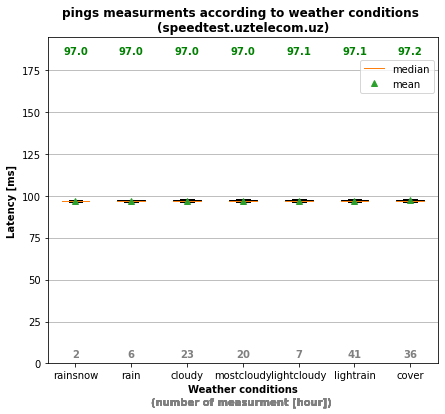

In [13]:
xl = len(weather_sorted_by_mean_ping)
graphe_scale = weather_sorted_by_mean_ping[xl-1][1]*2

fig, ax = plt.subplots(figsize=(xl, 6))

#labels
ax.set_xticklabels(list_with_collumn(weather_sorted_by_mean_ping,0))
plt.ylim(0,graphe_scale)
ax.yaxis.grid()

scale_y = 1000
ylab = ax.get_xlabel()
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*scale_y))
ax.yaxis.set_major_formatter(ticks_y)

#boxplot
for i in range(xl):
    bp = ax.boxplot(weather_pings[weather_sorted_by_mean_ping[i][0]], positions = [i], widths=0.5, showmeans = True, showfliers=False)
plt.title('pings measurments according to weather conditions \n(' + serv + ')', fontweight='bold')
plt.ylabel('Latency [ms]', fontweight='bold')
plt.xlabel('Weather conditions', fontweight='bold')

if(serv in full_serv):
    #text
    for i in range(xl):
        ax.text(i, graphe_scale/50,weather_type_measurment[weather_sorted_by_mean_ping[i][0]] , horizontalalignment='center',size='medium', weight='bold',color="grey")
for i in range(xl):
    ax.text(i, graphe_scale - graphe_scale/20,"{:.1f}".format(round(weather_sorted_by_mean_ping[i][1],4)*1000) , horizontalalignment='center',size='medium', weight='bold',color="green")
        
    plt.figtext(0.51, 0.03, '(number of measurment [hour])', fontsize='medium', color='gray', ha ='center', weight='bold')

#legend
plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'], loc=(0.80,0.83))

#save
#plt.savefig('../plot/'+ serv +'_home.pdf')  

plt.show()

### Bande passante

In [14]:
bw_weather_array = fusion_with_weather(bw_array, weather_array)

Remove NaN from bw_weather_array

In [15]:
to_delete = []
for i in range(len(bw_weather_array)):
    if(pd.isna(bw_weather_array[i][1])):
        to_delete.append(i)
bw_weather_array = np.delete(bw_weather_array, to_delete, axis=0)

In [16]:
weather_bw_dict = create_weather_bw_dict(weather_type, bw_weather_array)
weather_dl = dict_weather_all_bw(weather_bw_dict,'dl')
weather_up = dict_weather_all_bw(weather_bw_dict,'up')

In [17]:
weather_mean_dl = mean_bw_resp_weather(weather_bw_dict,'dl')
print('mean download : \n')
weather_sorted_by_mean_dl = print_dict_as_sorted_tuble(weather_mean_dl) #if no data, no entry
print("\n\n")
weather_mean_up = mean_bw_resp_weather(weather_bw_dict,'up')
print('mean upload : \n')
weather_sorted_by_mean_up = print_dict_as_sorted_tuble(weather_mean_up) #if no data, no entry

mean download : 

[('rainsnow', 61199440.07388234), ('mostcloudy', 67124608.2615704), ('cloudy', 68073881.88127536), ('cover', 70245752.45069051), ('lightrain', 70966426.2629628), ('rain', 75347311.84736365), ('lightcloudy', 75389117.93675509)]



mean upload : 

[('mostcloudy', 14612295.778831474), ('cloudy', 14716762.017177377), ('rainsnow', 14897271.106170213), ('lightcloudy', 15171041.173257211), ('lightrain', 15592817.705262855), ('cover', 15698846.591502886), ('rain', 15901346.090636062)]


**Plot Download**

<ipython-input-18-6ccf22acef0f>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_with_collumn(weather_sorted_by_mean_dl,0))


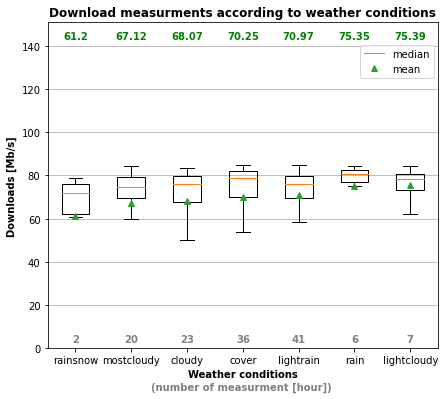

In [18]:
xl = len(weather_sorted_by_mean_dl)
graphe_scale = weather_sorted_by_mean_dl[xl-1][1]*2

fig, ax = plt.subplots(figsize=(xl, 6))

#labels
ax.set_xticklabels(list_with_collumn(weather_sorted_by_mean_dl,0))
plt.ylim(0,graphe_scale)
ax.yaxis.grid()

scale_y = 1_000_000
ylab = ax.get_xlabel()
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

#boxplot
for i in range(xl):
    bp = ax.boxplot(weather_dl[weather_sorted_by_mean_dl[i][0]], positions = [i], widths=0.5, showmeans = True, showfliers=False)
plt.title('Download measurments according to weather conditions', fontweight='bold')
plt.ylabel('Downloads [Mb/s]', fontweight='bold')
plt.xlabel('Weather conditions', fontweight='bold')

#text
for i in range(xl):
    ax.text(i, graphe_scale/50,weather_type_measurment[weather_sorted_by_mean_dl[i][0]] , horizontalalignment='center',size='medium', weight='bold',color="grey")
    ax.text(i, graphe_scale - graphe_scale/20,round(weather_sorted_by_mean_dl[i][1]/scale_y,2) , horizontalalignment='center',size='medium', weight='bold',color="green")
    
plt.figtext(0.51, 0.03, '(number of measurment [hour])', fontsize='medium', color='gray', ha ='center', weight='bold')

#legend
plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'], loc=(0.80,0.83))

#save
#plt.savefig('../plot/download_home.pdf')  

plt.show()

**Plot Upload**

<ipython-input-19-22262017fc60>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_with_collumn(weather_sorted_by_mean_up,0))


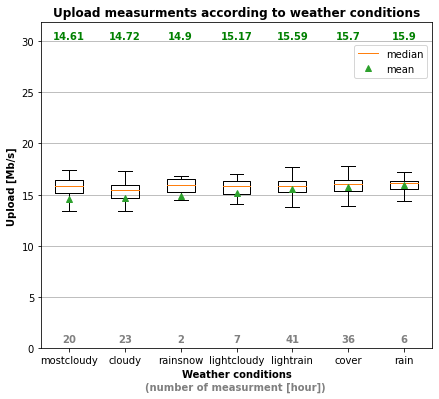

In [19]:
xl = len(weather_sorted_by_mean_up)
graphe_scale = weather_sorted_by_mean_up[xl-1][1]*2

fig, ax = plt.subplots(figsize=(xl, 6))

#labels
ax.set_xticklabels(list_with_collumn(weather_sorted_by_mean_up,0))
plt.ylim(0,graphe_scale)
ax.yaxis.grid()

scale_y = 1_000_000
ylab = ax.get_xlabel()
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

#boxplot
for i in range(xl):
    bp = ax.boxplot(weather_up[weather_sorted_by_mean_up[i][0]], positions = [i], widths=0.5, showmeans = True, showfliers=False)
plt.title('Upload measurments according to weather conditions', fontweight='bold')
plt.ylabel('Upload [Mb/s]', fontweight='bold')
plt.xlabel('Weather conditions', fontweight='bold')

#text
for i in range(xl):
    ax.text(i, graphe_scale/50,weather_type_measurment[weather_sorted_by_mean_up[i][0]] , horizontalalignment='center',size='medium', weight='bold',color="grey")
    ax.text(i, graphe_scale - graphe_scale/20,round(weather_sorted_by_mean_up[i][1]/scale_y,2) , horizontalalignment='center',size='medium', weight='bold',color="green")
plt.figtext(0.51, 0.03, '(number of measurment [hour])', fontsize='medium', color='gray', ha ='center', weight='bold')

#legend
plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'], loc=(0.80,0.83))

#save
#plt.savefig('../plot/upload_home.pdf')  

plt.show()

## Perte de Paquets

In [20]:
weather_lost = mean_lost_resp_weather(weather_ping_measure_dict)
sort_weather_lost = print_dict_as_sorted_tuble(weather_lost)

[('rain', 0.0), ('rainsnow', 0.0), ('cloudy', 0.0004347826086956522), ('lightrain', 0.0019704433497536953), ('lightcloudy', 0.002857142857142857), ('mostcloudy', 0.0034999999999999996), ('cover', 0.0058333333333333345)]


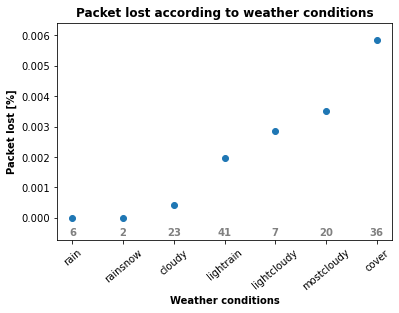

In [21]:
scale = sort_weather_lost[len(sort_weather_lost)-1][1]

plt.scatter(*zip(*sort_weather_lost))
plt.ylim(-scale/8, sort_weather_lost[len(sort_weather_lost)-1][1]*1.1)
plt.xticks(rotation=40)

for i in range(xl):
    plt.text(i, -scale/10,weather_type_measurment[sort_weather_lost[i][0]] , horizontalalignment='center',size='medium', weight='bold',color="grey")

plt.title('Packet lost according to weather conditions', fontweight='bold')
plt.ylabel('Packet lost [%]', fontweight='bold')
plt.xlabel('Weather conditions', fontweight='bold')

plt.savefig('../plot/lost.pdf')
plt.show()